# Librerias

In [116]:
import pandas as pd
import numpy as np
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from scipy.stats import f_oneway

# pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Funciones

In [117]:
def nas(df):
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(columns = {0:'Valores_perdidos',1 : 'Valores_Perd_Porc'})
    mz_table['Valores_Perd_Porc'] = mz_table['Valores_Perd_Porc'] # + mz_table['Zero Values'] 
    mz_table['Tipo_dato'] = df.dtypes
    mz_table = mz_table[mz_table.iloc[:,1] != 0].sort_values('Valores_Perd_Porc', ascending=False).round(1)
    print ("El data frame tiene " + str(df.shape[1]) + " columnas y " + str(df.shape[0]) + " filas.\n"      
        "Hay " + str(mz_table.shape[0]) +
          " columnas que tienen valores perdidos.")
    return mz_table

# Función que detecta NAN y no da errores con los strings.
def isNAN(x):
   return (x is np.nan or x != x) 


# Suponiendo que para las variables con poca proporción de NAN queremos eliminar
# aquellas filas con algún valor de este tipo, esta función calcula la cantidad
# de filas a eliminar dado un límite bajo el cual no admitimos NAN en los valores
# de una variable.
def numNANrowsUnder(dataNAS, percentLimitToDrop=10):
    numColsToExclude = sum(dataNAS.Valores_Perd_Porc > percentLimitToDrop)
    colsToInclude = dataNAS.index[numColsToExclude:]
    dataToDrop = data[colsToInclude].copy()
    
    numRowsToDrop = 0
    for row in range(len(dataToDrop)):
        for column in range(dataToDrop.shape[1]):
            if isNAN(dataToDrop.iloc[row, column]):
                numRowsToDrop += 1
                break
    
    return(numRowsToDrop)


# 1. Descripción del dataset. ¿Por qué es importante y qué pregunta/problema pretende responder?

El dataset escogido es importante porque permite evidenciar la percepción académica, de uso y de calidad de información para los docentes,  del repositorio <a href="https://es.wikipedia.org/wiki/Wikipedia:Portada" target="_blnak">Wikipedia</a>. Los datos provienen de una encuesta enviada a profesores a tiempo parcial y a tiempo completo en dos universidades españolas en 2012-2013: Universitat Oberta de Catalunya (<a href="https://www.uoc.edu/">UOC</a>) y Universitat Pompeu Fabra (<a href="https://www.upf.edu/es/">UPF</a>).


En esta idea, el <b>dataset</b> ofrece la oportunidad de conocer, a través de una encuesta realizada con variables categoricas, discretas y continuas, cual es la percepción de los docentes de educación superior con respecto al aporte de wikipedia, como herramienta que contribuya, con su información, a los estudiantes.

Pregunta problema: <b>¿Cuál es la percepción de los docentes de las universidades UOC y UPF con respecto a wikipedia como herramienta de colaboración a los estudiantes?</b>

## 2. Integración y selección de los datos de interés a analizar.

Inicialmente, se cargaran los datos y se realizará una descripción estadística general; de igual forma, se presentaran los primeros registros con el fin de conocer los valores tomados por variable:  

## Carga de Datos

In [118]:
data = pd.read_csv('wiki4HE.csv', sep=";")
print("El dataset cuenta con ", data.shape[0], " filas y ", data.shape[1], " variables")
data.head()

El dataset cuenta con  913  filas y  53  variables


,AGE,GENDER,DOMAIN,PhD,YEARSEXP,UNIVERSITY,UOC_POSITION,OTHER_POSITION,OTHERSTATUS,USERWIKI,PU1,PU2,PU3,PEU1,PEU2,PEU3,ENJ1,ENJ2,Qu1,Qu2,Qu3,Qu4,Qu5,Vis1,Vis2,Vis3,Im1,Im2,Im3,SA1,SA2,SA3,Use1,Use2,Use3,Use4,Use5,Pf1,Pf2,Pf3,JR1,JR2,BI1,BI2,Inc1,Inc2,Inc3,Inc4,Exp1,Exp2,Exp3,Exp4,Exp5
0,40,0,2,1,14,1,2,?,?,0,4,4,3,5,5,3,4,4,3,3,2,2,3,3,3,1,2,4,2,4,4,4,3,1,1,2,4,1,1,3,4,1,2,3,5,5,5,5,4,4,4,1,2
1,42,0,5,1,18,1,2,?,?,0,2,3,3,4,4,3,3,4,4,4,3,3,2,3,3,1,1,2,1,4,4,4,2,2,1,1,2,1,1,1,4,3,2,2,4,4,3,4,2,2,4,2,4
2,37,0,4,1,13,1,3,?,?,0,2,2,2,4,4,3,3,3,2,2,2,5,3,2,3,2,2,4,3,4,2,4,1,1,1,1,1,3,3,3,4,3,1,1,5,3,5,5,2,2,2,1,3
3,40,0,4,0,13,1,3,?,?,0,3,3,4,3,3,3,4,3,3,4,3,3,3,3,4,3,2,2,3,5,5,5,3,3,3,3,3,4,4,4,5,4,3,3,3,4,4,3,4,4,3,3,4
4,51,0,6,0,8,1,3,?,?,1,4,3,5,5,4,3,4,4,4,5,4,3,4,4,4,4,3,2,3,5,5,5,3,3,5,5,5,5,5,5,3,3,5,5,5,5,4,4,5,5,5,4,4


### Resumen

In [119]:
data.describe()

,AGE,GENDER,PhD,UNIVERSITY
count,913.000000,913.000000,913.000000,913.000000
mean,42.246440,0.424973,0.464403,1.123768
std,8.058418,0.494610,0.499005,0.329497
min,23.000000,0.000000,0.000000,1.000000
25%,36.000000,0.000000,0.000000,1.000000
50%,42.000000,0.000000,0.000000,1.000000
75%,47.000000,1.000000,1.000000,1.000000
max,69.000000,1.000000,1.000000,2.000000


Como se logra observar en el resumen anterior, de las 53 variables, tan solo 4 (__AGE, GENDER, PhD y University__) han sido tomadas como numéricas. Con esto, se debe realizar un cambio de tipos de variable. También, es de mencionar que este dataset podría ser dividido en 2 datasets: __variables demográficas__ y __variables de aspecto sobre wikipedia__.

#### Tipos de Datos (por defecto)

A continuación se observa como python ha cargado los datos, así como su tipo de variable:

In [120]:
data.columns.to_series().groupby(data.dtypes).groups

{dtype('int64'): Index(['AGE', 'GENDER', 'PhD', 'UNIVERSITY'], dtype='object'),
 dtype('O'): Index(['DOMAIN', 'YEARSEXP', 'UOC_POSITION', 'OTHER_POSITION', 'OTHERSTATUS',
        'USERWIKI', 'PU1', 'PU2', 'PU3', 'PEU1', 'PEU2', 'PEU3', 'ENJ1', 'ENJ2',
        'Qu1', 'Qu2', 'Qu3', 'Qu4', 'Qu5', 'Vis1', 'Vis2', 'Vis3', 'Im1', 'Im2',
        'Im3', 'SA1', 'SA2', 'SA3', 'Use1', 'Use2', 'Use3', 'Use4', 'Use5',
        'Pf1', 'Pf2', 'Pf3', 'JR1', 'JR2', 'BI1', 'BI2', 'Inc1', 'Inc2', 'Inc3',
        'Inc4', 'Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5'],
       dtype='object')}

#### Tipos de Datos (modificados)

In [121]:
vars_no_category = ["AGE", "YEARSEXP"]
for col in data.loc[:, ~data.columns.isin(vars_no_category)].columns:
    data[col] = data[col].astype('category')


##### Resumen Tipos de variable

In [122]:
pd.DataFrame(data.dtypes, columns=['Tipo'])

,Tipo
AGE,int64
GENDER,category
DOMAIN,category
PhD,category
YEARSEXP,object
UNIVERSITY,category
UOC_POSITION,category
OTHER_POSITION,category
OTHERSTATUS,category
USERWIKI,category


Ahora bien, se observa que la variable __YEARSEXP__ ha sido cargada como "object" a pesar de que es numerica (según la descripción de la <a href="https://archive.ics.uci.edu/ml/datasets/wiki4HE">página del set oficial</a>). Sin embargo, esta variable cuenta con valores nulos, por lo que sera tratada en un apartado siguiente.

#### Conocimiento de los datos: Variables Demográficas

A continuación se presentan las variables demográficas del dataset:

|                | Descripción variable |
|----------------|:---------------------|
| AGE            | Age of Professor     |
| GENDER         | Male or Female       |
| DOMAIN         | Area of Expertise: Arts & Humanities; Sciences; Health Sciences; Engineering & Architecture; Law & Politics; Social Sciences |
| PhD            | Has PhD or Not       | 
| YEAREXP        | Years of university teaching experience  |
| UNIVERSITY     | Universitat Oberta de Catalunya (UOC) or Universitat Pompeu Fabra (UPF). |
| UOC_POSITION   | Professor; Associate; Assistant; Lecturer; Instructor; Adjunct |
| OTHER          | For part time members, states if main job in another university |
| OTHER_POSITION | People who work as part time in another university and UPF members |
| USERWIKI       | Wether a registered Wikipedia user or not |

#### Conocimiento de las variables de aspecto

In [123]:
var = ["Perceived Usefulness", "Perceived Ease of Use", "Perceived Enjoyment", 
            "Quality", "Visibility", "Social Image", "Sharing Attitude", "Use Behaviour",
            "Profile 2.0", "Job relevance","Behavioral intention ", "Incentives","Experience"]
descrip = ["""PU1: The use of Wikipedia makes it easier for students to develop new skills,
           PU2: The use of Wikipedia improves students learning,
PU3: Wikipedia is useful for teaching """,
                """PEU1: Wikipedia is user-friendly,
PEU2: It is easy to find in Wikipedia the information you seek,
PEU3: It is easy to add or edit information in Wikipedia \n""",
                """ENJ1: The use of Wikipedia stimulates curiosity ,
ENJ2: The use of Wikipedia is entertaining """,
                """QU1: Articles in Wikipedia are reliable,
QU2: Articles in Wikipedia are updated ,
QU3: Articles in Wikipedia are comprehensive,
QU4: In my area of expertise, Wikipedia has a lower quality than other educational resources,
QU5: I trust in the editing system of Wikipedia """, 
                """VIS1: Wikipedia improves visibility of students' work,
VIS2: It is easy to have a record of the contributions made in Wikipedia,
VIS3: I cite Wikipedia in my academic papers """,
                """IM1: The use of Wikipedia is well considered among colleagues,
IM2: In academia, sharing open educational resources is appreciated,
IM3: My colleagues use Wikipedia """, 
                """SA1: It is important to share academic content in open platforms,
SA2: It is important to publish research results in other media than academic journals or books,
SA3: It is important that students become familiar with online collaborative environments """, 
                """USE1: I use Wikipedia to develop my teaching materials,
USE2: I use Wikipedia as a platform to develop educational activities with students,
USE3: I recommend my students to use Wikipedia,
USE4: I recommend my colleagues to use Wikipedia,
USE5: I agree my students use Wikipedia in my courses """, 
                """PF1: I contribute to blogs,
PF2: I actively participate in social networks,
PF3: I publish academic content in open platforms """, 
               """JR1: My university promotes the use of open collaborative environments in the Internet,
JR2: My university considers the use of open collaborative environments in the Internet as a teaching merit """,
                """BI1: In the future I will recommend the use of Wikipedia to my colleagues and students,
BI2: In the future I will use Wikipedia in my teaching activity """,
                """INC1: To design educational activities using Wikipedia, it would be helpful: a best practices guide,
INC2: To design educational activities using Wikipedia, it would be helpful: getting instruction from a colleague,
INC3: To design educational activities using Wikipedia, it would be helpful: getting specific training,
INC4: To design educational activities using Wikipedia, it would be helpfull: greater institutional recognition """,
                """EXP1: I consult Wikipedia for issues related to my field of expertise,
EXP2: I consult Wikipedia for other academic related issues,
EXP3: I consult Wikipedia for personal issues,
EXP4: I contribute to Wikipedia (editions, revisions, articles improvement...) ,
EXP5: I use wikis to work with my students"""]
pd.DataFrame(descrip, var, columns=['Descripción variable'])

,Descripción variable
Perceived Usefulness,PU1: The use of Wikipedia makes it easier for ...
Perceived Ease of Use,"PEU1: Wikipedia is user-friendly,\nPEU2: It is..."
Perceived Enjoyment,ENJ1: The use of Wikipedia stimulates curiosit...
Quality,"QU1: Articles in Wikipedia are reliable,\nQU2:..."
Visibility,VIS1: Wikipedia improves visibility of student...
Social Image,IM1: The use of Wikipedia is well considered a...
Sharing Attitude,SA1: It is important to share academic content...
Use Behaviour,USE1: I use Wikipedia to develop my teaching m...
Profile 2.0,"PF1: I contribute to blogs,\nPF2: I actively p..."
Job relevance,JR1: My university promotes the use of open co...


# 3 Limpieza de los datos.

## 3.1 ¿Los datos contienen ceros o elementos vacíos? ¿Cómo gestionarías cada uno de estos casos?

#### Validación de Nulos y valores perdidos

Se ha realizado una función que obtiene los valores nulos y su proporción con respecto al dataset

In [124]:
nas(data)

El data frame tiene 53 columnas y 913 filas.
Hay 0 columnas que tienen valores perdidos.


,Valores_perdidos,Valores_Perd_Porc,Tipo_dato


#### Cantidad de Variables con valores atípicos

En una primera impresión, se resalta que los datos cuentan con un valor atípico ('?'), el cual inicialmente no es capturado por funciones de identificación de nan. Por esto, se realizó una búsqueda con _isin_ para obtener todas aquellas columnas con estos valores:

In [125]:
print(data[data.isin(['?'])].dropna(how='all').count())

AGE                 0
GENDER              0
DOMAIN              2
PhD                 0
YEARSEXP           23
UNIVERSITY          0
UOC_POSITION      113
OTHER_POSITION    261
OTHERSTATUS       540
USERWIKI            4
PU1                 7
PU2                11
PU3                 5
PEU1                4
PEU2               14
PEU3               97
ENJ1                7
ENJ2               17
Qu1                 7
Qu2                10
Qu3                15
Qu4                22
Qu5                29
Vis1               72
Vis2              117
Vis3                8
Im1                22
Im2                20
Im3                57
SA1                11
SA2                12
SA3                11
Use1               14
Use2               17
Use3                9
Use4               23
Use5               15
Pf1                11
Pf2                 6
Pf3                14
JR1                27
JR2                53
BI1                32
BI2                43
Inc1               35
Inc2      

Como se pudó observar en el anterior paso, algunas variables cuentan con valores "?", por lo que a continuación se presenta un conteo por variable:

In [126]:
for col in data.loc[:, ~data.columns.isin(vars_no_category)].columns:
    print(data.groupby([col]).size().reset_index(name='cantidad'))

  GENDER  cantidad
0      0       525
1      1       388
  DOMAIN  cantidad
0      1       183
1      2        56
2      3        73
3      4       137
4      5       101
5      6       361
6      ?         2
  PhD  cantidad
0   0       489
1   1       424
  UNIVERSITY  cantidad
0          1       800
1          2       113
  UOC_POSITION  cantidad
0            1         3
1            2        68
2            3        50
3            4        18
4            5         2
5            6       659
6            ?       113
  OTHER_POSITION  cantidad
0              1       268
1              2       384
2              ?       261
  OTHERSTATUS  cantidad
0           1        19
1           2       130
2           3        24
3           4        36
4           5        16
5           6        41
6           7       107
7           ?       540
  USERWIKI  cantidad
0        0       784
1        1       125
2        ?         4
  PU1  cantidad
0   1        35
1   2       216
2   3       330
3 

Una vez comprendido que los valores perdidos han sido etiquetados con un caracter especial, se procede a reemplazarlo con _nan_ con el fin de hacer uso de la función de valores perdidos y su proporción en el dataset:

In [127]:
data = data.replace('?', np.nan)
nas(data)

El data frame tiene 53 columnas y 913 filas.
Hay 49 columnas que tienen valores perdidos.


,Valores_perdidos,Valores_Perd_Porc,Tipo_dato
OTHERSTATUS,540,59.1,category
OTHER_POSITION,261,28.6,category
Vis2,117,12.8,category
UOC_POSITION,113,12.4,category
PEU3,97,10.6,category
Vis1,72,7.9,category
Im3,57,6.2,category
JR2,53,5.8,category
BI2,43,4.7,category
Inc4,42,4.6,category


Como se puede observar, existen 49 variables con valores perdidos; siendo _OTHERSTATUS_ la variable con mayor datos perdidos, alcanzando un 59.1% de datos perdidos con respecto al dataset.

#### Estimación de filas a eliminar
Cálculo de las filas que nos quedarían si eliminamos las filas con algún NAN en aquellas variables con menos de un 10% de NA:

In [128]:
dataNAS = nas(data)

print("Para un 10% eliminaríamos el ",
      numNANrowsUnder(dataNAS, percentLimitToDrop=10)*100/data.shape[0], "% de las filas.")
print("Para un 7% eliminaríamos el ",
      numNANrowsUnder(dataNAS, percentLimitToDrop=7)*100/data.shape[0], "% de las filas.")
print("Para un 5% eliminaríamos el ",
      numNANrowsUnder(dataNAS, percentLimitToDrop=5)*100/data.shape[0], "% de las filas.")
print("Para un 2% eliminaríamos el ",
      numNANrowsUnder(dataNAS, percentLimitToDrop=2)*100/data.shape[0], "% de las filas.")


El data frame tiene 53 columnas y 913 filas.
Hay 49 columnas que tienen valores perdidos.
Para un 10% eliminaríamos el  30.339539978094194 % de las filas.
Para un 7% eliminaríamos el  28.14895947426068 % de las filas.
Para un 5% eliminaríamos el  26.50602409638554 % de las filas.
Para un 2% eliminaríamos el  15.443592552026287 % de las filas.


#### Conversión de tipos de variables
Convertimos a numérico YEARSEXP y a boleano USERWIKI y PhD.

In [129]:
# Convertir años de experiencia a numérico
data.YEARSEXP = pd.to_numeric(data.YEARSEXP).copy()

# Convertir PhD a booleano
data.PhD = data.PhD.astype("bool")

# Para convertir USERWIKI a booleano eliminaremos los 4 casos que no respondieron a esta pregunta.
data = data.dropna(subset=['USERWIKI']).copy()
data.USERWIKI = data.USERWIKI.astype("bool")

#### Gestión de los valores perdidos
Dado que los datos provienen de un cuestionario online, y que no existen preguntas llave ni combinaciones de respuestas incompatibles, suponemos que todos los valores perdidos son preguntas sin contestar.

##### Variables demográficas
**USERWIKI**
Como hemos visto en el apartado anterior, los 4 registros que incluían valores perdidos en la variable USERWIKI han sido eliminados.

**OTHERSTATUS** y **OTHER_POSITION** Estas dos variables presentan un rango de valores en los datos diferente al proporcionado en el codebook que acompaña al dataset. No cabe una interpretación clara de un error de transcripción o error tipográfico, por lo que se decide eliminar ambas variables.

In [130]:
data = data.drop(columns=['OTHERSTATUS', 'OTHER_POSITION']).copy()

**UOC_POSITION** y **DOMAIN** Al rango de valores inicial (números enteros 1 y 2) se añade el 0, que codificará para "No responde."

In [131]:
data.UOC_POSITION = data.UOC_POSITION.cat.remove_unused_categories().copy()
data.UOC_POSITION = data.UOC_POSITION.cat.set_categories(["0", "1", "2"]).copy()
data.UOC_POSITION[data.UOC_POSITION.isna()] = "0"

data.DOMAIN = data.DOMAIN.cat.set_categories(["0", "1", "2", "3", "4", "5", "6"]).copy()
data.DOMAIN[data.DOMAIN.isna()] = "0" 

**YEARSEXP** Vemos que la mediana de los datos es representativa y usamos este valor para imputar los valores perdidos.

count    886.000000
mean      10.887133
std        7.463108
min        0.000000
25%        5.000000
50%       10.000000
75%       15.000000
max       43.000000
Name: YEARSEXP, dtype: float64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


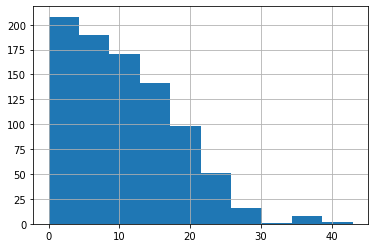

In [132]:
data.YEARSEXP.hist()
print(data.YEARSEXP.describe())
data.YEARSEXP[data.YEARSEXP.isna()] = data.YEARSEXP.median()

Observemos ahora cuantos valores perdidos nos quedan y cuantos registros nos quedarían si decidieramos eliminar todos aquellos que contengan algún valor perdido.

In [133]:
dataNAS = nas(data)
print(dataNAS)
filasEliminadas = numNANrowsUnder(dataNAS, percentLimitToDrop=100)
print("Si elimináramos todas las filas con valores perdidos nos quedaríamos con ", data.shape[0]-filasEliminadas,
      " filas, que supone una pérdida del ", filasEliminadas*100/data.shape[0],
      "% de las filas.")


El data frame tiene 51 columnas y 909 filas.
Hay 43 columnas que tienen valores perdidos.
      Valores_perdidos  Valores_Perd_Porc Tipo_dato
Vis2               115               12.7  category
PEU3                96               10.6  category
Vis1                71                7.8  category
Im3                 56                6.2  category
JR2                 52                5.7  category
BI2                 41                4.5  category
Inc4                40                4.4  category
Inc3                36                4.0  category
Inc1                34                3.7  category
Inc2                34                3.7  category
BI1                 31                3.4  category
Qu5                 29                3.2  category
JR1                 26                2.9  category
Qu4                 22                2.4  category
Use4                22                2.4  category
Im1                 21                2.3  category
Im2                 19    

#### Variables sobre Wikipedia
Vemos que el resto de variables con valores perdidos corresponden con las percepciones de los encuestados sobre la Wikipedia. Según [el artículo](http://openaccess.uoc.edu/webapps/o2/bitstream/10609/39441/1/Meseguer_et_al_preprintJASIST.pdf) para el que se recogieron los datos las respuestas corresponden a una escala Likert, por lo que tiene sentido tratarlas como variables numéricas. Procedemos por tanto a su conversión, conservando los datos perdidos en forma de objetos NaN de Numpy.

In [134]:
for column in data.columns[8:]:
    data[column] = pd.to_numeric(data[column])
data.dtypes

AGE                int64
GENDER          category
DOMAIN          category
PhD                 bool
YEARSEXP         float64
UNIVERSITY      category
UOC_POSITION    category
USERWIKI            bool
PU1              float64
PU2              float64
PU3              float64
PEU1             float64
PEU2             float64
PEU3             float64
ENJ1             float64
ENJ2             float64
Qu1              float64
Qu2              float64
Qu3              float64
Qu4              float64
Qu5              float64
Vis1             float64
Vis2             float64
Vis3             float64
Im1              float64
Im2              float64
Im3              float64
SA1              float64
SA2              float64
SA3              float64
Use1             float64
Use2             float64
Use3             float64
Use4             float64
Use5             float64
Pf1              float64
Pf2              float64
Pf3              float64
JR1              float64
JR2              float64


## 3.2 Identificación y tratamiento de valores extremos.

Ahora que nuestras dos variables numéricas están correctamente transformadas procedemos a buscar valores extremos.

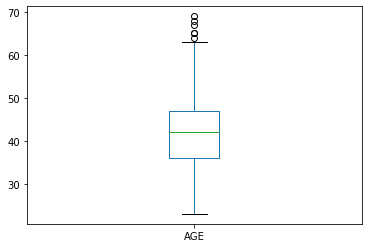

In [135]:
# Edad
data.AGE.plot.box()

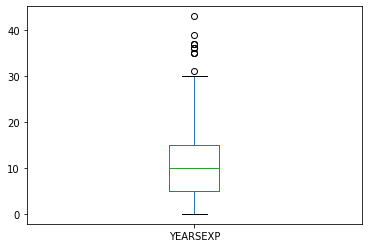

In [136]:
# Años de experiencia
data.YEARSEXP.plot.box()

Si bien la variable YEARSEXP presenta varios outliers, la distribución de los datos parece tener sentido y no es demasiado extrema, por lo que se decide conservar todos los datos.


# 4 Análisis de los datos.

## 4.1 Selección de los grupos de datos que se quieren analizar/comparar (planificación de los análisis a aplicar)
Se realizarán distintos análisis relacionando los datos demográficos de los encuestados con sus percepciones dobre la Wikipedia.

Las percepciones sobre la Wikipedia se presentan agrupadas en distintas categorías, lo que nos permite la creación de variables que recojan la puntuación media de cada grupo para cada encuestado.
Crearemos también una variable de puntuación media global.

Estas variables serán redondeadas a números enteros y categorizadas ordinalmente.

In [137]:
data['G_PU'] = pd.Series([0]*data.shape[0])
data['G_PEU'] = pd.Series([0]*data.shape[0])
data['G_ENJ'] = pd.Series([0]*data.shape[0])
data['G_QU'] = pd.Series([0]*data.shape[0])
data['G_VIS'] = pd.Series([0]*data.shape[0])
data['G_IM'] = pd.Series([0]*data.shape[0])
data['G_SA'] = pd.Series([0]*data.shape[0])
data['G_USE'] = pd.Series([0]*data.shape[0])
data['G_PF'] = pd.Series([0]*data.shape[0])
data['G_JR'] = pd.Series([0]*data.shape[0])
data['G_BI'] = pd.Series([0]*data.shape[0])
data['G_INC'] = pd.Series([0]*data.shape[0])
data['G_EXP'] = pd.Series([0]*data.shape[0])
data['GLOBAL'] = pd.Series([0]*data.shape[0])

for row in data.index:
    for group in data.columns[51:]:
        colPrefix = group[2:].lower()
        groupValues = []
        for column in data.columns[8:]:
            lowercol = column.lower()
            if lowercol.startswith(colPrefix):
                myvalue = data.loc[row, column]
                if not np.isnan(myvalue):
                    groupValues.append(data.loc[row, column])
        data.loc[row, group] = np.mean(groupValues)
    data.loc[row, 'GLOBAL'] = np.mean(data.loc[row, "G_PU":"G_EXP"])

data.iloc[:,51:].describe()

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,G_PU,G_PEU,G_ENJ,G_QU,G_VIS,G_IM,G_SA,G_USE,G_PF,G_JR,G_BI,G_INC,G_EXP,GLOBAL
count,905.000000,907.000000,907.000000,902.000000,908.000000,899.000000,905.000000,909.000000,907.000000,884.000000,881.000000,887.000000,904.000000,909.000000
mean,3.246961,3.958471,3.804851,3.177790,2.613620,2.885799,4.232044,2.496443,2.561191,3.417986,2.971623,3.538895,2.841611,3.209505
std,0.899681,0.636979,0.830210,0.599082,0.791760,0.811517,0.759440,0.924355,1.086558,1.031664,1.045983,0.941148,0.783685,0.533727
min,1.000000,1.333333,1.000000,1.200000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.482051
25%,2.666667,3.666667,3.000000,2.800000,2.000000,2.333333,4.000000,1.800000,1.666667,3.000000,2.000000,3.000000,2.200000,2.852564
50%,3.333333,4.000000,4.000000,3.200000,2.666667,3.000000,4.333333,2.400000,2.333333,3.500000,3.000000,3.500000,2.800000,3.202564
75%,4.000000,4.333333,4.500000,3.600000,3.000000,3.333333,5.000000,3.200000,3.333333,4.000000,4.000000,4.250000,3.400000,3.575641
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


#### Gestión de los valores perdidos en las nuevas variables

In [138]:
# Buscamos filas con NA en las variables de grupo
numRowsToDrop = 0
for row in range(data.shape[0]):
     for column in range(51, data.shape[1]):
         if isNAN(data.iloc[row, column]):
             numRowsToDrop += 1
             break
print(numRowsToDrop)

58


In [139]:
# Solo son 58, así que las borramos.
data = data.dropna(subset=data.columns[51:]).copy()

## 4.2 Comprobación de la normalidad y homogeneidad de la varianza.
Primeramente, comprobamos la normalidad de las variables que hemos generado sobre los grupos de preguntas sobre la Wikipedia.

G_PU


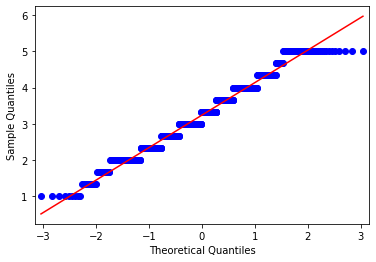

G_PEU


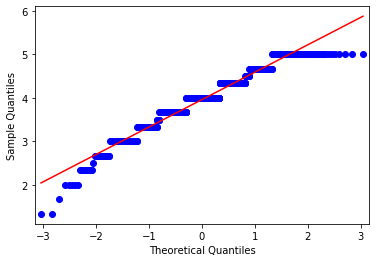

G_ENJ


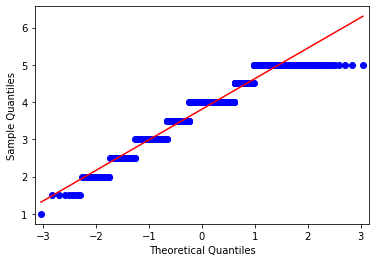

G_QU


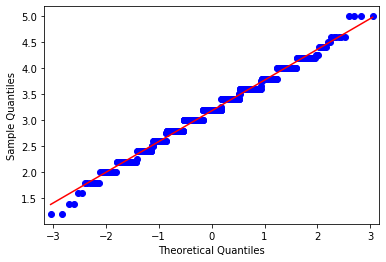

G_VIS


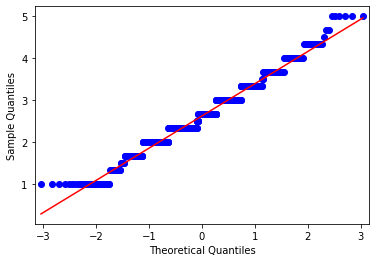

G_IM


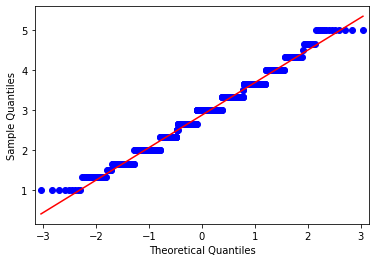

G_SA


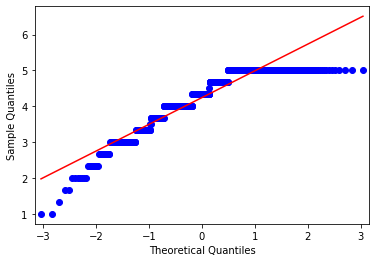

G_USE


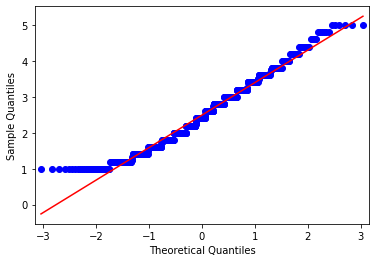

G_PF


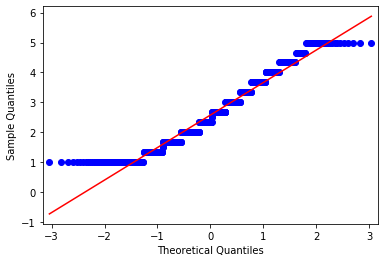

G_JR


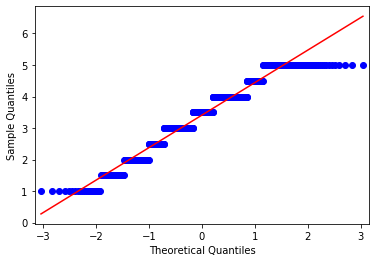

G_BI


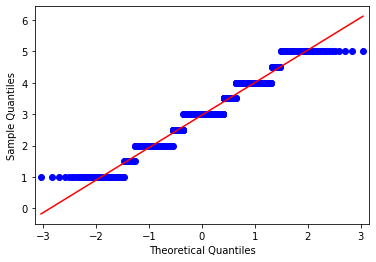

G_INC


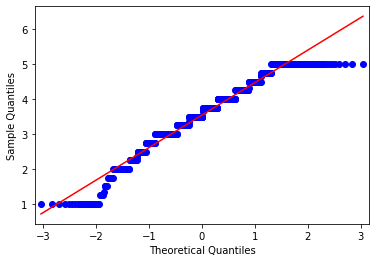

G_EXP


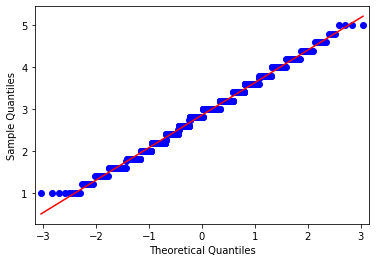

GLOBAL


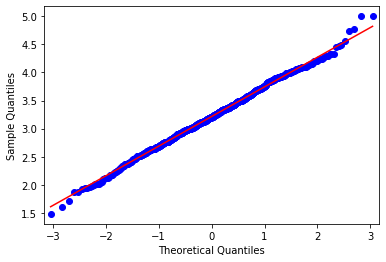

In [140]:
for group in range(51, data.shape[1]):
    print(data.columns[group])
    qqplot(data.iloc[:,group], line='s')
    pyplot.show()
pyplot.show()

Como podemos ver, todas estas variables se distribuyen de forma más o menos normal.

Continuamos analizando las dos varibles numéricas del grupo de variables demográficas.

Edad


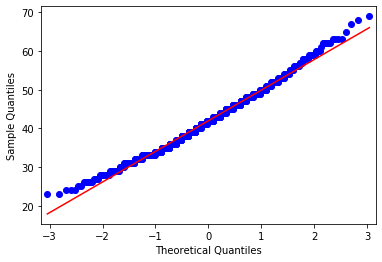

Años de experiencia


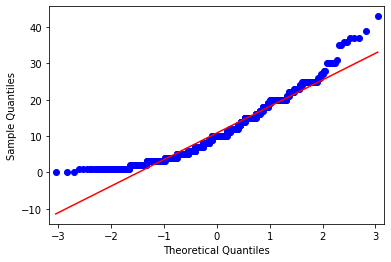

In [141]:
print("Edad")
qqplot(data.AGE, line='s')
pyplot.show()
print("Años de experiencia")
qqplot(data.YEARSEXP, line='s')
pyplot.show()

Vemos como la edad se distribuye calaramente de forma normal, y si bien los años de experiencia parecen tomar otra distribución ligeramente diferente, esta parece aproximarse bastante a la normal.

#### Conversión de las nuevas variables a categóricas
Una vez calculada la normalidad de las nuevas variables, procedemos a convertirlas en categóricas.

In [142]:
for column in data.columns[51:]:
    data[column] = round(data[column])
    data[column] = pd.Categorical(data[column], [1, 2, 3, 4, 5], ordered=True)

#### Análisis de la varianza

In [143]:
f_oneway(data.AGE, data.YEARSEXP)

count     851
unique      5
top         3
freq      328
Name: G_PU, dtype: int64

La función `F_oneway` comprueba la hipótesis de que las varianzas de ambas muestras provengan de la misma población. Con un pvalue de 0.0 no podemos afirmar que ambas varianzas sean similares, sin embargo esto no será necesario para las pruebas que pretendemos llevar a cabo.

No se calcula la varianza de las nuevas variables porque estas serán tratadas como categóricas.

## 4.3 Aplicación de pruebas estadísticas para comparar los grupos de datos. En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes
### Regresión logarítmica
Realizamos una regresión logarítmica entre las variables demográficas y las variables de grupo que hemos creado.

In [145]:
predictions = pd.DataFrame()
y_tests = pd.DataFrame()
f1_score_data = pd.Series()
models = pd.Series()

for column in data.columns[51:]:
    X_train, X_test, y_train, y_test = train_test_split(data.loc[:,'AGE':'USERWIKI'], 
                                                        data[column], test_size=0.30, 
                                                        random_state=101)
    logmodel = LogisticRegression(solver='saga', multi_class="auto", max_iter=5000)
    logmodel.fit(X_train,y_train)
    predictions[column] = logmodel.predict(X_test)
    y_tests[column] = y_test
    models[column] = logmodel
    f1_score_data[column] = f1_score(y_tests[column], predictions[column], average='micro')

Para medir la bondad del ajuste calculamos los valores F1 para cada variable ordenándolas de mayor a menor:

In [146]:
f1_ranking = f1_score_data.sort_values(ascending=False)
print(f1_ranking)

G_ENJ     0.621094
GLOBAL    0.613281
G_PEU     0.597656
G_QU      0.582031
G_EXP     0.472656
G_IM      0.468750
G_INC     0.460938
G_VIS     0.457031
G_JR      0.453125
G_PU      0.398438
G_SA      0.394531
G_USE     0.351562
G_PF      0.300781
G_BI      0.277344
dtype: float64


Veamos en detalle los resultados del test sobre los dos modelos que mejor han puntuado:

In [147]:
print([f1_ranking.index[0]])
print(classification_report(y_tests[f1_ranking.index[0]],predictions[f1_ranking.index[0]]))

print([f1_ranking.index[1]])
print(classification_report(y_tests[f1_ranking.index[1]],predictions[f1_ranking.index[1]]))

['G_ENJ']
              precision    recall  f1-score   support

           2       0.00      0.00      0.00        25
           3       0.00      0.00      0.00        26
           4       0.63      0.99      0.77       161
           5       0.00      0.00      0.00        44

    accuracy                           0.62       256
   macro avg       0.16      0.25      0.19       256
weighted avg       0.40      0.62      0.48       256

['GLOBAL']
              precision    recall  f1-score   support

           2       0.00      0.00      0.00        20
           3       0.63      0.96      0.76       161
           4       0.22      0.03      0.05        74
           5       0.00      0.00      0.00         1

    accuracy                           0.61       256
   macro avg       0.21      0.25      0.20       256
weighted avg       0.46      0.61      0.49       256



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Parece ser que el modelo desarrollado para las variables `G_ENJ` y `GLOBAL` no ha conseguido ser mejor que el uso de la moda como predictor de cada variable, lo cual podemos comprobar observando el recuento valores predecidos:

In [155]:
print("G_ENJ")
predictions.G_ENJ.value_counts()

G_ENJ


4    253
3      3
Name: G_ENJ, dtype: int64

In [156]:
print("GLOBAL")
predictions.GLOBAL.value_counts()

GLOBAL


3    247
4      9
Name: GLOBAL, dtype: int64

### 5 Representación de los resultados a partir de tablas y gráficas.

### 6 Resolución del problema. A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?